Using device: cuda
Fold 1/5
Epoch 1/20
Train Loss: 1.6953, Train Accuracy: 0.181
Val Loss: 0.3519, Val Accuracy: 0.079
Epoch 2/20
Train Loss: 1.1081, Train Accuracy: 0.408
Val Loss: 0.1759, Val Accuracy: 0.143
Epoch 3/20
Train Loss: 0.5831, Train Accuracy: 0.616
Val Loss: 0.1064, Val Accuracy: 0.170
Epoch 4/20
Train Loss: 0.3567, Train Accuracy: 0.689
Val Loss: 0.0888, Val Accuracy: 0.173
Epoch 5/20
Train Loss: 0.2550, Train Accuracy: 0.721
Val Loss: 0.0740, Val Accuracy: 0.178
Epoch 6/20
Train Loss: 0.1689, Train Accuracy: 0.751
Val Loss: 0.0881, Val Accuracy: 0.174
Epoch 7/20
Train Loss: 0.1286, Train Accuracy: 0.762
Val Loss: 0.0739, Val Accuracy: 0.179
Epoch 8/20
Train Loss: 0.0935, Train Accuracy: 0.772
Val Loss: 0.0933, Val Accuracy: 0.176
Epoch 9/20
Train Loss: 0.0716, Train Accuracy: 0.778
Val Loss: 0.0901, Val Accuracy: 0.177
Epoch 10/20
Train Loss: 0.0509, Train Accuracy: 0.784
Val Loss: 0.0800, Val Accuracy: 0.179
Epoch 11/20
Train Loss: 0.0231, Train Accuracy: 0.795
Val Los

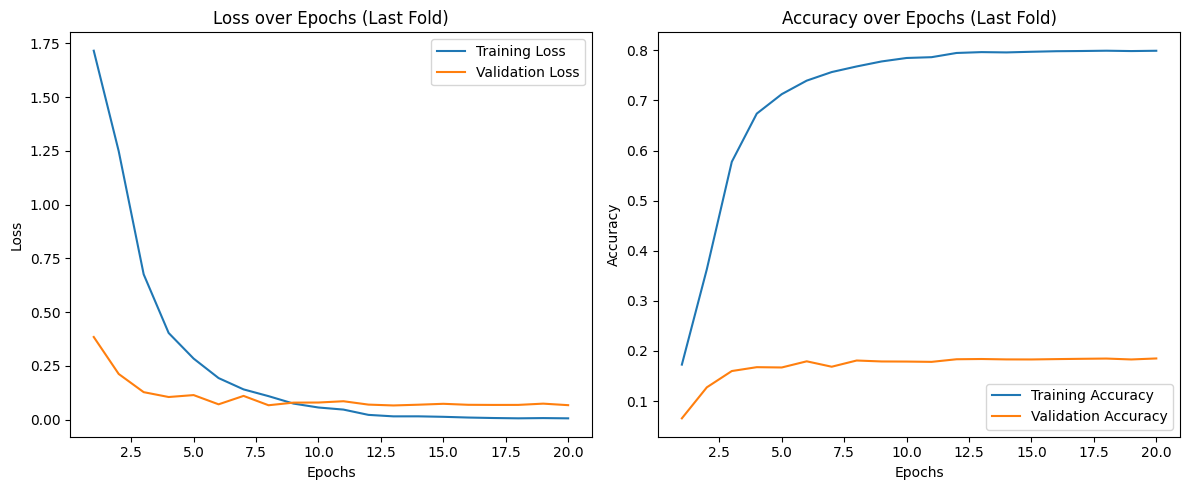

In [2]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Prepare dataset
def prepareData(file_name):
    train_data = np.loadtxt(file_name, delimiter=',')
    y = train_data[:, 0]
    X = train_data[:, 1:] / 255.
    # Reshape input data for single-channel images (28x84)
    X = X.reshape(-1, 1, 28, 84)  # 1 channel, size 28x84
    # Convert to PyTorch Tensors
    tensor_X = torch.Tensor(X)
    tensor_y = torch.LongTensor(y)
    dataset = TensorDataset(tensor_X, tensor_y)  # create PyTorch TensorDataset
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # create PyTorch DataLoader
    return dataset, dataloader

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # input: 1 channel
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # pooling layer

        # Fully connected layers
        # Need to calculate the correct size after pooling operations
        self.fc1 = nn.Linear(512 * 1 * 5, 1024)  # Update dimensions if needed
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)  # output layer for 10 classes
        self.dropout = nn.Dropout(0.2)  # dropout for regularization

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # flatten the tensor for the fully connected layers

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)  # final layer
        output = F.log_softmax(x, dim=1)  # softmax for multi-class classification

        return output

# Training loop
def train(model, optimizer, train_dataloader, device):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_dataloader.dataset)
    accuracy = correct / len(train_dataloader.dataset)
    return train_loss, accuracy

# Test loop
def test(model, test_dataloader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    accuracy = correct / len(test_dataloader.dataset)
    return test_loss, accuracy

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Prepare datasets
dataset, _ = prepareData('sample_data/A4train.csv')  # Full dataset, without splitting
test_dataset, test_dataloader = prepareData('sample_data/A4val.csv')

# K-Fold Cross Validator
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store overall performance metrics
# Initialize lists to store overall performance metrics
fold_train_losses, fold_train_accuracies = [], []
fold_test_losses = []  # Correct initialization for test losses
fold_test_accuracies = []  # Correct initialization for test accuracies

# Training with k-fold cross-validation
n_epochs = 20
early_stop_threshold = 0.20

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}/{k_folds}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_dataloader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
    val_dataloader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_loss = float('inf')
    early_stop_triggered = False
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train(model, optimizer, train_dataloader, device)
        val_loss, val_acc = test(model, val_dataloader, device)
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.3f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.3f}")

        if val_loss > best_val_loss + early_stop_threshold:
            print(f"Early stopping triggered.")
            early_stop_triggered = True
            break
        best_val_loss = min(best_val_loss, val_loss)

    test_loss, test_acc = test(model, test_dataloader, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.3f}")

    fold_train_losses.append(train_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_test_losses.append(test_loss)  # Collect test losses per fold
    fold_test_accuracies.append(test_acc)  # Collect test accuracies per fold


# Calculate average metrics
mean_test_loss = np.mean(fold_test_losses)
mean_test_accuracy = np.mean(fold_test_accuracies)
print(f"Average Test Loss: {mean_test_loss:.4f}")
print(f"Average Test Accuracy: {mean_test_accuracy:.3f}")

# Visualize training metrics for the last fold
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title(f'Loss over Epochs (Last Fold)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy over Epochs (Last Fold)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
